<a href="https://colab.research.google.com/github/frasercrichton/fastai2-learning/blob/master/nbs/TripleChaserFastAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai==2.0
!pip install fastai --upgrade
from fastai.vision.all import *

# !pip install fastai==2.0
# import fastai
# print(fastai. version ) # should be 2.0.0
# from fastai.vision.all import *


     |████████████████████████████████| 358kB 4.5MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 358kB 4.8MB/s 
  Found existing installation: fastai 2.0.0
    Uninstalling fastai-2.0.0:
      Successfully uninstalled fastai-2.0.0


In [2]:
%matplotlib inline
bs = 64     # default batch size
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install utils
from utils import *

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  26120      0 --:--:-- --:--:-- --:--:-- 26120
OK
74 packages can be upgraded. Run 'apt list --upgradable' to see them.
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)


<IPython.core.display.Javascript object>

Authenticate against GCP related

In [4]:
from google.colab import auth
auth.authenticate_user()

In [5]:
!rm -rf "data" 
!mkdir "data"
!rm -rf "download" 
!mkdir "download"
project_id = "forensic-265906"
!gcloud config set project {project_id}
!gsutil -m cp -r gs://forensic-architecture-machine-learning/canisters/canisters.zip download/canisters.zip


Updated property [core/project].
Copying gs://forensic-architecture-machine-learning/canisters/canisters.zip...
- [1/1 files][276.4 MiB/276.4 MiB] 100% Done                                    
Operation completed over 1 objects/276.4 MiB.                                    


In [6]:
%%capture
!rm -rf "data" 
!unzip "download/canisters.zip" 

## Examine the contents of the bucket

Lets get the bucket and have a look at how it's annotated . . .

In [7]:
!ls data/canisters/real_val/

ann  img


In [8]:
path = Path('data/canisters/real_val/'); path

Path('data/canisters/real_val')

Now lets see some of those images

In [9]:
annotations_path = path/'ann'
images_path = path /'img'
 #augmentations = augmentations

fnames = get_image_files(images_path)
fnames

(#265) [Path('data/canisters/real_val/img/zbatch2__collected28jun11.png'),Path('data/canisters/real_val/img/1549463519988.png'),Path('data/canisters/real_val/img/IMG_0408.jpeg'),Path('data/canisters/real_val/img/1550488912155.jpeg'),Path('data/canisters/real_val/img/1550508268761.png'),Path('data/canisters/real_val/img/1550488919151.jpeg'),Path('data/canisters/real_val/img/1549385092200.png'),Path('data/canisters/real_val/img/20190220__1550160361578.jpeg'),Path('data/canisters/real_val/img/zbatch2__19nov2011tahrir5.png'),Path('data/canisters/real_val/img/zbatch2__Venez07mixed.png')...]

Work towards adding this into a 'utility' class

In [11]:
# no idea what to call this at the moment but this will do for now
class BasicDataHolder():

  def __init__(self,
        path: Union[str, Path]):
    self.annotations_path = path/'ann'
    self.images_path = path /'img'
    #augmentations = augmentations don't need as fastai does it
    self.image_filenames = get_image_files(self.images_path)
    #print(self.image_filenames[0])

    self.images = list(
      sorted(
        filter(
          lambda _pth: _pth.suffix.lstrip(".").lower()
          in {"jpeg", "jpg", "png"},
          self.images_path.iterdir(),
        )
      )
    )
    #print(self.images[0])
    self.annotationsDict = { 
      image_file.name : 
      self.annotations_path / f"{image_file.name}.json"           
      for image_file in self.images
    }
    #print(self.annotationsDict['1000w_q95.jpeg'])

  def getImageFiles(self):
    return self.images

  def getAnnotationsDict(self) -> (dict):
    return self.annotationsDict


#BasicDataHolder(path).getImageFiles()

# annotation_data["objects"]

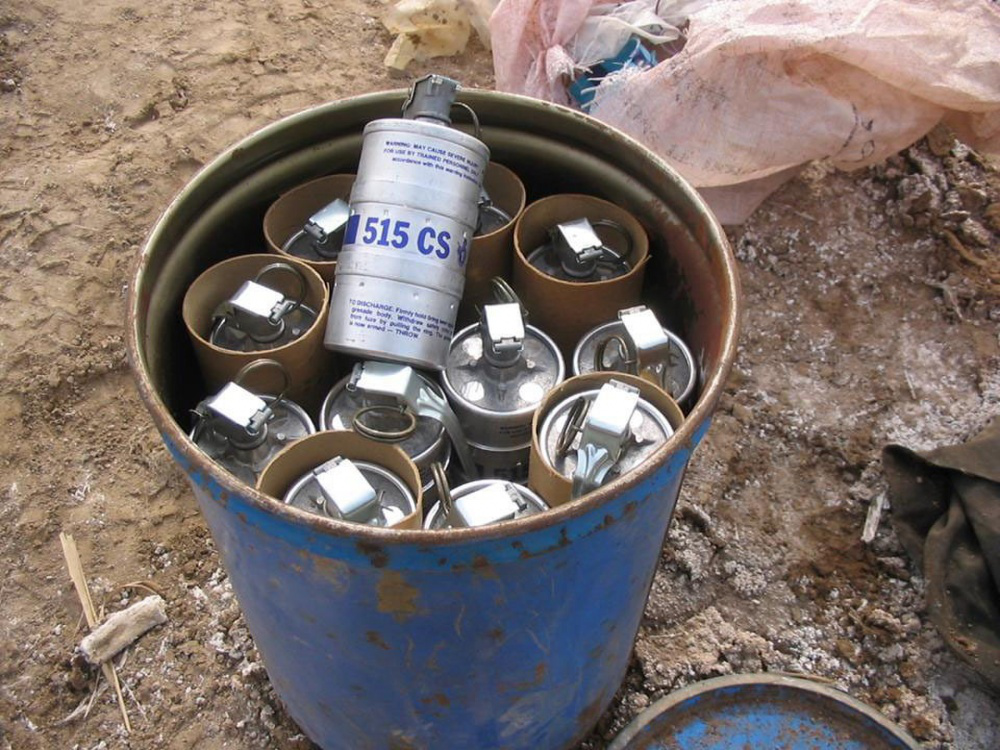

In [12]:

#base_image = Image.open(self.images[idx]).convert("RGB")
#annotation_data = json.loads(self.annotations[idx].read_text())
base_image = Image.open(BasicDataHolder(path).getImageFiles()[0]).convert("RGB")
base_image


In [24]:
# -> (Image, Image, dict)
# self, 


from PIL import Image, ImageDraw
from typing import Tuple, Union, Callable, Optional

def random_rgb():
  return tuple(np.random.randint(0, 256, 3))

def random_hex():
    return rgb_to_hex(random_rgb())


def rgb_to_hex(rgb: Tuple[int, int, int]) -> str:
    return "#%02x%02x%02x" % rgb

class ImageHelper():
  # add other labels
  #labels=["triplechaser-poly", "tripletop-poly"]
  #labels=["triplechaser", "tripletop"]
  labels=["triple_chaser_bitmap"]
  

  ds_type = 'DOWNLOADED'
  #ds_type = 'NOT_DOWNLOADED'
  

  def __init__(self,
               labelclass="triplechaser"
               ):
    self
    self.labelclass = labelclass

  def load_with_meta(self, 
                     image: Image, 
                     annotation_data: dict,
                     maskType: string):
    """ Consumes the original image and annotation_data from JSON, and 
        returns a tuple (img, masks, meta): the original image, an image 
        with the masks, as well as a meta_output dict. """
    imsize = image.size[0] * image.size[1]
    masks = Image.new(mode="RGB", size=image.size)
    mask_drawer = ImageDraw.Draw(masks)
    meta_output = defaultdict(list)
    # 'poly' 'bitmap'
    mask_type = maskType
    labels = {}
    print(annotation_data["objects"])
    # something wrong here - need to look at the structure of the JSON again to work out if this
    # has a mask or a bounding box/both/or none
    if mask_type == 'poly':
            for obj in annotation_data["objects"]:
                for label in self.labels:
                    print(obj["classTitle"])
                    if obj["classTitle"] == label:
                        print(obj)
                        
                        col = random_rgb()
                        meta_output[self.labelclass].append(rgb_to_hex(col))
                        mask_drawer.polygon(
                            [tuple(xy) for xy in obj["points"]["exterior"]], fill=col
                        )
                        break

            return image, masks, meta_output

          
BasicDataHolder(path).getAnnotationsDict()["1000w_q95.jpeg"]

Path('data/canisters/real_val/ann/1000w_q95.jpeg.json')

In [26]:
# 1548757385802.png
# annotation_data = json.loads(file.read_text()) # this can't be the most performant really
# # 'poly' 'bitmap'
annotations_json = json.loads(BasicDataHolder(path).getAnnotationsDict()['1000w_q95.jpeg'].read_text())
imageHelper = ImageHelper().load_with_meta(base_image, 
                                           annotations_json,
                                           'poly')
imageHelper[1]


[{'description': '', 'bitmap': None, 'tags': [{'name': '2', 'value': None}], 'classTitle': 'triplechaser', 'points': {'exterior': [[319.0, 61.0], [490.0, 381.0]], 'interior': []}}, {'bitmap': {'origin': [321, 74], 'data': 'eJwBOgLF/YlQTkcNChoKAAAADUlIRFIAAACvAAABKgEDAAAAWVaS6QAAAAZQTFRFAAAA////pdmf3QAAAAF0Uk5TAEDm2GYAAAHiSURBVHicvdmxkYQgGAVgHAOzowRKsaXrQEqjFEogNGDkdsVd5efBiYImO/MF8sD/GayMBdcvQ1e3QOZOIR6dReyck7EOLzYxixeDRZ1Dd+kxc8xiZbgi4LGIJwdzJ9iVcJfj6MD7Ih5yPFPmRSyK2J+rOclTEbsc65M8XWBFeazBIsfyJHPI/sET9pNGp945xO5fVpgNWC+ckyMvmA/BA1aYDea9Dv2RF8z7miFrzAazxfw9xCFkiVljnjFbzJ998pBdgiVmhVljNpi34IKwLeIFs0uwxOz3M1LWmA3mGbPF7INP99jWY6rbdh7l9WC7Nqwz3N9kVY2Hsywb8vpw+JO84FpWYXuBx3uceBNc4Ymyac5Ut9dgG1YZjttaxrIax21NMKvGUS2X59mPN2/C8wUW99jU45Gybsi+I9OTLHNMtZBZNY7binmpx1Fb7fPsxztqaxU2F5jfY32BxUlWDdmP9/gksxxPt3i5wvTWZWzrcdTW+Xn24x21tQrrHEe1LGNVj/lJlg3Zj4l4kLfxHluwvcLTLZ4rMtHPX0FlLDDTNT9Miqk3JjP75fAQd2YJPpZQ7XxMeeRDyoA7zHtKGfA3JWGW4B5z6uuJTxmpTxnzmhLwOyVihr76vFNiZj/+5w/RSZDdc67JNQAAAABJRU5ErkJggmfKDtg='

TypeError: ignored

data/canisters/real_val/ann/1000w_q95.jpeg.json


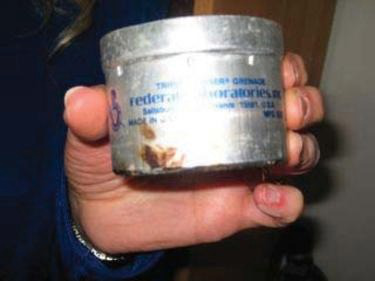

In [15]:
images = list(
  sorted(
    filter(
      lambda _pth: _pth.suffix.lstrip(".").lower()
      in {"jpeg", "jpg", "png"},
      images_path.iterdir(),
    )
  )
)
images[0]

Path('data/canisters/real_val/img/1000w_q95.jpeg')

In [16]:
annotationsDict = { 
  image_file.name : 
  annotations_path / f"{image_file.name}.json"           
  for image_file in images
}
annotationsDict['1000w_q95.jpeg']

Path('data/canisters/real_val/ann/1000w_q95.jpeg.json')

In [17]:
def label_func(imagePath):
  image_name = imagePath.name
  file = BasicDataHolder(path).getAnnotationsDict()[image_name]# annotationsDict[image_name]
  annotation_data = json.loads(file.read_text()) # this can't be the most performant really
  if annotation_data["objects"]:
    return annotation_data["objects"][0]["classTitle"]
  else: 
    return "label"
label_func(Path('1550508269245.png'))


'canister-general-bbox'

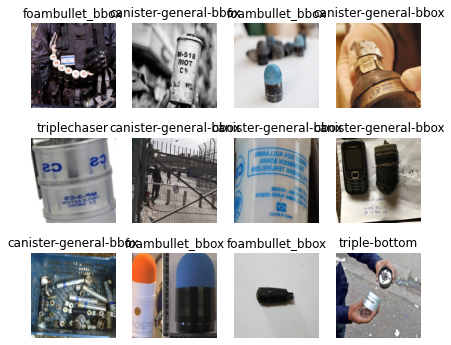

In [18]:
dls = ImageDataLoaders.from_path_func(images_path, fnames, label_func,
                                      item_tfms=RandomResizedCrop(460, min_scale=0.75), bs=bs//2,
                                     batch_tfms=[*aug_transforms(size=299, max_warp=0), Normalize.from_stats(*imagenet_stats)])
# , item_tfms=Resize(460), bs=bs, batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
dls.show_batch(max_n=12, figsize=(7,6))

In [23]:
print(dls.vocab)
len(dls.vocab),dls.c

(#8) ['canister-general-bbox','foambullet_bbox','label','triple-bottom','triple-top','triple_bottom_bitmap','triple_chaser_bitmap','triplechaser']


(8, 8)

In [20]:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fit_one_cycle(10)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,3.194400,1.797162,0.641509,00:16
1,3.341400,1.844920,0.566038,00:15
2,2.733817,1.570515,0.377358,00:16
3,2.210286,1.331233,0.283019,00:15
4,1.808962,1.153268,0.264151,00:15
5,1.502614,1.095177,0.226415,00:15
6,1.272756,0.978725,0.245283,00:15
7,1.094502,0.898719,0.245283,00:15
8,0.944508,0.883512,0.207547,00:15
9,0.832627,0.880188,0.226415,00:15


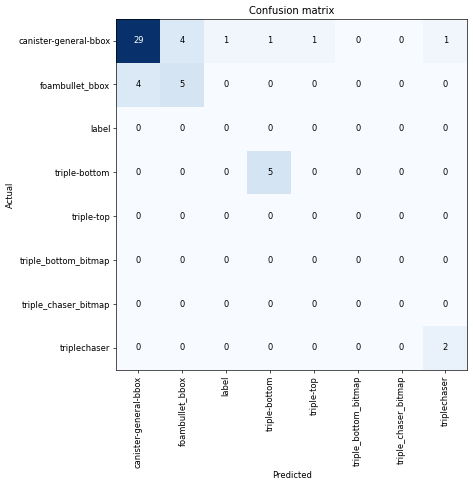

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)